In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable

from nbodykit.lab import *

from colossus.cosmology import cosmology
cosmo_c = cosmology.setCosmology('planck15')

In [5]:
def measure_autopk(array,L):
    mesh = ArrayMesh(array,BoxSize=L)
    r = FFTPower(mesh, mode='1d')
    return r.power

In [6]:
def noise(nc):
    np.random.seed(0)
    a = np.random.normal(loc=0, scale=1, size=(nc,nc,nc))
    deltapk = np.fft.fftn(a)/np.sqrt(nc**3)
    return deltapk 

In [7]:
L=512
nc=256
wn = noise(nc)
a = measure_autopk(wn,L)

[]

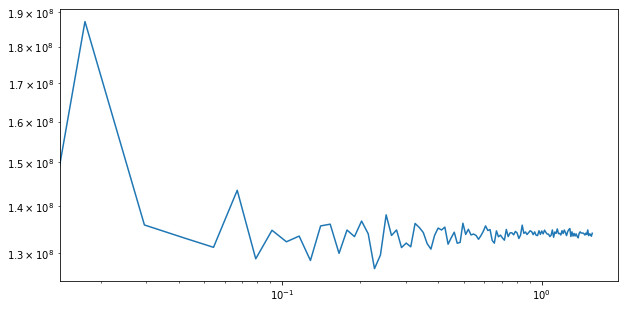

In [8]:
plt.figure(figsize=(10,5))
plt.plot(a['k'].real,a['power'].real)
plt.loglog()

In [9]:
k,p = np.loadtxt('Pk.input_zinit_normalized_at_z0.DAT',unpack=True)
p*=cosmo_c.growthFactor(100)*cosmo_c.growthFactor(100)

In [10]:
"""Create k^2 in box (nc x nc x nc)"""
def k_box(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.transpose(np.indices((nc,nc,nc)).T, (2, 1, 0, 3)) #1 grid cell 3 coordinates
    k2=(k[a]**2).sum(axis=-1) # each grid cell is sum of squares of coordinates
    return (np.sqrt(k2.astype(np.float16)))

In [11]:
"""Create k_x,y,z in box (nc x nc x nc)"""
def k_box_val(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.transpose(np.indices((nc,nc,nc)).T, (2, 1, 0, 3)) #1 grid cell 3 coordinates
    kval=k[a] # each grid cell is sum of squares of coordinates
    return (kval.astype(np.float16))

In [12]:
def plot_slice(a1,start):
    cmap = plt.get_cmap('jet')
    start = start
    c = a1[:,start,:]
    #c = scipy.ndimage.interpolation.zoom(c ,order=1, zoom=2)
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)

    im = plt.imshow((c.T),vmin=-.1,vmax=0.1,interpolation='bilinear',origin='lower',aspect='auto',cmap=cmap)
    ax.set_aspect('equal')

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "5%", pad="2%")
    cb = plt.colorbar(im,orientation='vertical',cax=cax)
    cb.ax.get_yaxis().labelpad = 0.
    plt.show()

In [13]:
kbox = k_box(nc,L)
Pk_box = np.interp(kbox,k,p)

In [14]:
wnpk = wn *np.sqrt(Pk_box/L**(3)*nc**(6))
a1 = np.fft.ifftn(wnpk)

In [15]:
b1 = measure_autopk(a1.real,L)

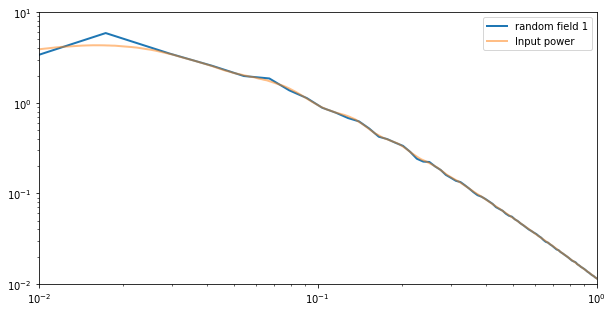

In [16]:
plt.figure(figsize=(10,5))
plt.plot(b1['k'].real,b1['power'].real,lw=2,label="random field 1")
plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,1)
plt.ylim(1E-2,1E1)
plt.legend()

In [18]:
delta_lin = np.fromfile('deltaLOGN_1000.dat',dtype=np.float32).reshape(nc,nc,nc)
delta_k = np.fft.fftn(delta_lin)

In [19]:
"""Augment resolution in Fourier space"""
nc2 = 2*nc
kbox2 = k_box(nc2,L)
Pk_box2 = np.interp(kbox2,k,p)
wn2 = noise(nc2)
wnpk2 = wn2 * np.sqrt(Pk_box2/L**(3)*(nc2)**(6))
a2 = np.fft.ifftn(wnpk2)

In [20]:
"""get indices of modes in high res box that are also in low res box"""
kboxval = k_box_val(nc,L)
kboxval2 = k_box_val(nc2,L)

iindt = np.isin(kboxval2,kboxval)
ii = iindt.all(axis=-1)

In [21]:
"""replace phases in high res box with low res ones"""

wnpk2c = np.copy(wnpk2)
wnpk2c[ii]=delta_k.ravel()*8

In [22]:
cgrf = np.fft.ifftn(wnpk2c)

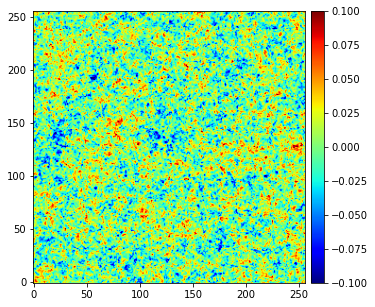

In [23]:
plot_slice(delta_lin,int(nc/2))

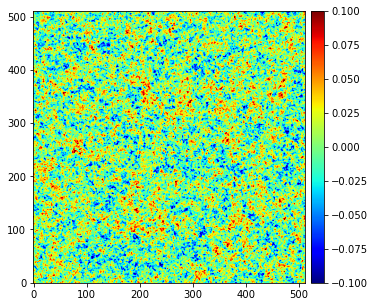

In [24]:
plot_slice(a2.real,int(nc2/2))

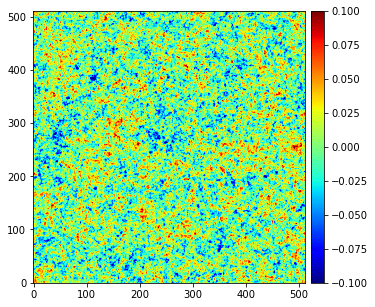

In [25]:
plot_slice(cgrf.real,int(nc2/2))

In [26]:
pk_delta = measure_autopk(cgrf.real,L)
pk_deltain = measure_autopk(delta_lin,L)

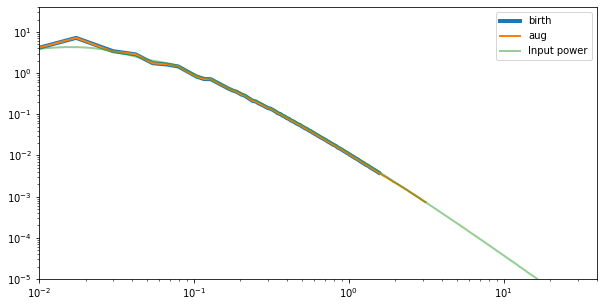

In [24]:
plt.figure(figsize=(10,5))
plt.plot(pk_deltain['k'].real,pk_deltain['power'].real,lw=4,label="birth")
plt.plot(pk_delta['k'].real,pk_delta['power'].real,lw=2,label="aug")
plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,40)
plt.ylim(1E-5,4E1)
plt.legend()